<a href="https://colab.research.google.com/github/andresmasegosa/Estadistica_GradoInformatica_UAL_18_19/blob/master/PAC_MNIST_ExponentialDistribution2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/Images'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Set-Up



In [3]:
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fontsize = 18
matplotlib.rcParams.update({'font.size': fontsize})
from matplotlib.pyplot import figure

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D

from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam



from __future__ import absolute_import, division, print_function, unicode_literals

In [4]:
assert(tf.test.gpu_device_name())
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True) # Enable XLA.

# Data

In [5]:
num_classes = 10
train_size = 1000

def load_data(data_set, train_size):
  (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
  #(x_test, y_test), (x_train, y_train) = datasets.mnist.load_data()
  
  tf.keras.utils.set_random_seed(123)
  a = np.random.permutation(x_train.shape[0])
  x_train = x_train[a ,...]
  y_train = y_train[a]




  x_test = np.concatenate([x_train[train_size:], x_test], 0)
  y_test = np.concatenate([y_train[train_size:], y_test], 0)

  x_train = x_train[:train_size,...]
  y_train = y_train[:train_size]
  # Add a new axis
  
  x_train = x_train[..., np.newaxis]
  x_test = x_test[..., np.newaxis]


  # Convert class vectors to binary class matrices.
  y_train = to_categorical(y_train, num_classes)
  y_test = to_categorical(y_test, num_classes)

  # Data normalization
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  return x_train, y_train, x_test, y_test

Load Fashion MNIST

In [6]:
x_train, y_train, x_test, y_test = load_data('mnist', train_size)

11490434/11490434 [==============================] - 1s 0us/step


In [7]:
print("Training samples:", x_train.shape[0])
print("Test samples:", x_test.shape[0])

Training samples: 1000
Test samples: 69000


# Loss Function

In [8]:
from tensorflow.keras.callbacks import Callback
import warnings

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [9]:
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten

def get_lenet(l2_reg = 0.0):
    tf.keras.utils.set_random_seed(123)

    LeNet_l2 = Sequential()
    LeNet_l2.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1), 
                kernel_regularizer=tf.keras.regularizers.L2(l2_reg),
                bias_regularizer=tf.keras.regularizers.L2(l2_reg)))
    LeNet_l2.add(MaxPool2D(strides=2))
    LeNet_l2.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu', 
                kernel_regularizer=tf.keras.regularizers.L2(l2_reg),
                bias_regularizer=tf.keras.regularizers.L2(l2_reg)))
    LeNet_l2.add(MaxPool2D(strides=2))
    LeNet_l2.add(Flatten())
    LeNet_l2.add(Dense(256, activation='relu', 
                kernel_regularizer=tf.keras.regularizers.L2(l2_reg),
                bias_regularizer=tf.keras.regularizers.L2(l2_reg)))
    LeNet_l2.add(Dense(84, activation='relu',
                kernel_regularizer=tf.keras.regularizers.L2(l2_reg),
                bias_regularizer=tf.keras.regularizers.L2(l2_reg)))
    LeNet_l2.add(Dense(10))

    LeNet_l2.build()
    cce = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True
    )


    adam = Adam(learning_rate=1e-3)
    LeNet_l2.compile(loss=cce, metrics=[cce, 'accuracy'], optimizer=adam)
    return LeNet_l2

# Training Set-up

In [10]:
def model_norm(model):
    norm = []
    for w in model.get_weights():
        norm.append(tf.norm(w))
    return np.sum(norm)

def model_relative_norm(model, model_reference):
    norm = []
    for i in range(len(model.get_weights())):
        norm.append(tf.norm(model.get_weights()[i]-model_reference.get_weights()[i]))
    return np.sum(norm)    

In [11]:
def train_and_evaluate(model, epochs, batch_size=train_size):
    callbacks = [EarlyStoppingByLossVal(monitor='categorical_crossentropy', value=0.00, verbose=1)]
    model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, callbacks = callbacks, verbose = 0)
    train_metrics = model.evaluate(x_train, y_train)
    test_metrics = model.evaluate(x_test, y_test)
    return train_metrics, test_metrics

In [12]:
def eval_jensen(model, lambdas):
    cce_red = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )
    y_pred = model.predict(x_test)
    log_p = -cce_red(y_test, y_pred)
    return np.array([(tfp.math.reduce_logmeanexp(lamb * log_p) - tf.reduce_mean(lamb * log_p)) for lamb in lambdas])

def jensen_function(model, lamb):
    cce_red = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )
    y_pred = model.predict(x_test)
    log_p = -cce_red(y_test, y_pred)
    return (tfp.math.reduce_logmeanexp(lamb * log_p))/lamb, tf.reduce_mean(log_p), (tfp.math.reduce_logmeanexp(lamb * log_p) - tf.reduce_mean(lamb * log_p))/lamb



def rate_function(model, lambdas, s_values):
  jensen_vals = eval_jensen(model, lambdas)
  def temp(s):
    if s>0:
      return np.max(lambdas[lambdas>0]*np.abs(s) - jensen_vals[lambdas>0])
    else:
      return np.max((-lambdas[lambdas<0])*np.abs(s) - jensen_vals[lambdas<0])
  
  return [temp(s) for s in s_values]

def rate_function_positive(model, lambdas, s_values):
  jensen_vals = eval_jensen(model, lambdas)

  return [ np.max(lambdas*s - jensen_vals) for s in s_values]


def rate_function_negative(model, lambdas, s_values):
  jensen_vals = eval_jensen(model, -lambdas)

  return [ np.max(lambdas*s - jensen_vals) for s in s_values]


def inverse_rate_function_alpha(model, lambdas, alpha_vals):
  jensen_vals = eval_jensen(model, lambdas)

  out = []
  for alpha in alpha_vals:
    vec = (jensen_vals + alpha)/lambdas
    index = np.argmin(vec)
    if index==len(lambdas)-1:
      raise Exception('Not enough high lambda range')

    out.append(vec[index])
  return out


def inverse_rate_function_alpha_negative(model, lambdas, alpha_vals):
  jensen_vals = eval_jensen(model, -lambdas)

  out = []
  for alpha in alpha_vals:
    vec = (jensen_vals + alpha)/lambdas
    index = np.argmin(vec)
    if index==len(lambdas)-1:
      raise Exception('Not enough high lambda range')

    if index==0:
      raise Exception('Not enough low lambda range')

    out.append(vec[index])
  return out


def inverse_rate_function(model, model_reference, lambdas, n_samples):
  jensen_vals = eval_jensen(model, lambdas)
  model_class_capacity = np.log((model_relative_norm(model, model_reference)+0.05)/0.05)*model.count_params()/n_samples

  inverse_rate_vals = (jensen_vals+model_class_capacity+np.log(lambdas.size/0.05))/lambdas

  return np.min(inverse_rate_vals), lambdas[np.argmin(inverse_rate_vals)]

def model_weights(model):
    norm = []
    for w in model.get_weights():
        norm.append(tf.reshape(w,[-1]))

    w_vals = []
    for w in norm:  
      w_vals.append(tf.reshape(w,[-1]))

    return tf.concat(w_vals,axis=0)



In [13]:
labels = np.arange(0, 600, 100)
labels

array([  0, 100, 200, 300, 400, 500])

# Train

In [14]:
models = [get_lenet(0) for _ in labels]

In [15]:
metrics = [train_and_evaluate(models[i], i, batch_size=train_size) for i in range(len(labels))]

2157/2157 [==============================] - 6s 3ms/step - loss: 1.9441 - categorical_crossentropy: 1.9441 - accuracy: 0.5607


2157/2157 [==============================] - 7s 3ms/step - loss: 1.7876 - categorical_crossentropy: 1.7876 - accuracy: 0.6713


# Plot Jensen-Gap and Rate Functions

In [16]:
lambdas = np.linspace(-0.5, 0.5, 100)
jensens = [eval_jensen(model, lambdas) for model in models]

2157/2157 [==============================] - 5s 2ms/step


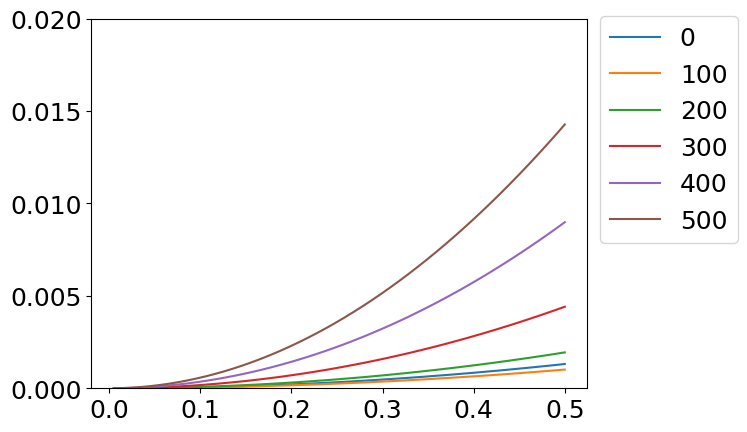

In [17]:
for i in np.arange(len(labels)):
    plt.plot(lambdas[lambdas > 0], jensens[i][lambdas > 0], label = "{}".format(labels[i]))
    plt.ylim(0,0.02)
plt.legend( bbox_to_anchor=(1, 1.04))
plt.show()

# Sampling $\alpha$ for a given model using data sets of size $batch\_size$

In [113]:
batch_size = 100
def get_alphas(model):

    batch_vals = []


    # eval_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    # eval_dataset = eval_dataset.shuffle(buffer_size=1024).batch(1000)

    # #L(\theta)
    # metric_test = model.evaluate(x_test, y_test, batch_size=batch_size)
    # L=metric_test[1]

    # for step, (x_batch, y_batch) in enumerate(eval_dataset):
    #     #\hatL(D_i,\theta)
    #     metric_batch = model.evaluate(x_batch, y_batch, batch_size=batch_size, verbose=False)
    #     batch_vals.append(metric_batch[1])


    #L(\theta)
    metric_test = model.evaluate(x_test, y_test, batch_size=1000)
    L=metric_test[1]

    cce_red = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )
    eval_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    eval_dataset = eval_dataset.shuffle(buffer_size=1024).batch(1000)
    for step, (x_batch, y_batch) in enumerate(eval_dataset):
      y_pred = model.predict(x_batch)
      log_p = cce_red(y_batch, y_pred)
      log_p =tf.expand_dims(log_p, axis=1)
      log_p=tf.reshape(log_p, [int(x_batch.shape[0]/batch_size), batch_size])
      log_p=tf.reduce_mean(log_p, axis=1)
      batch_vals.append(log_p)
      
    batch_vals = np.concatenate(batch_vals,axis=0)

    lambdas = np.arange(-10, 10, 0.01)

    total_alpha_vals = rate_function(model,lambdas,L-batch_vals)
    total_alpha_vals = batch_size*np.array(total_alpha_vals)*np.sign(L-batch_vals)

    # #alpha_vals = total_alpha_vals[L>batch_vals]

    return total_alpha_vals

In [114]:
def plot_alphas(alpha_vals):
    lambda_rate = 1#/np.mean(alpha_vals) #batch_size

    # Plot histogram
    plt.hist(alpha_vals, bins = 50, density=True)
    #plt.hist(data, bins=30, density=True, alpha=0.5)

    # Plot density
    x = np.linspace(0, np.log(1.0/0.0001)/lambda_rate, 1000)
    y = lambda_rate*np.exp(-lambda_rate * x)
    plt.plot(x, y, color='red')
    #plt.plot(-x, y, color='red')

    # Add labels and title
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Exponential Distribution')

    plt.show()

    alpha_vals = np.sort(alpha_vals)[::-1]
    sum = np.cumsum(alpha_vals)
    sum = sum/sum[-1]

    plt.plot( np.linspace(0, np.log(1.0/0.01)/lambda_rate, sum.shape[0]), sum)

    # # Plot density
    x = np.linspace(0, np.log(1.0/0.01)/lambda_rate, 1000)
    y = 1 - np.exp(-lambda_rate * x)
    plt.plot(x, y, color='red')
    # #plt.plot(-x, y, color='red')

    # # Add labels and title
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Exponential Distribution')

    # # Show the plot
    plt.show()

In [115]:
def test(alpha_vals):
    import numpy as np
    from scipy.stats import expon, kstest, anderson
    from scipy.stats import skew, kurtosis

    sk = skew(alpha_vals)
    kurt = kurtosis(alpha_vals)
    print("Skewness: ", sk)
    print("Kurtosis: ", kurt)
    # Define rate parameter

    #alpha_vals = alpha_vals[alpha_vals>np.percentile(alpha_vals, 50)]#-0.05

    rate = 1/np.mean(alpha_vals)
    print("Rate: ", 1/np.mean(alpha_vals))

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = kstest(alpha_vals, expon.cdf, args=(0, 1/rate))
    print('KS test statistic:', ks_statistic)
    print('KS test p-value:', p_value)

    # Perform Anderson-Darling test
    ad_statistic, critical_values, significance_levels = anderson(alpha_vals, 'expon')
    print('AD test statistic:', ad_statistic)
    print('AD critical values:', critical_values)
    print('AD significance levels:', significance_levels)

    return sk, kurt, p_value, ad_statistic, rate


In [116]:
alphas = [get_alphas(model) for model in models]

2157/2157 [==============================] - 5s 2ms/step


(340,)


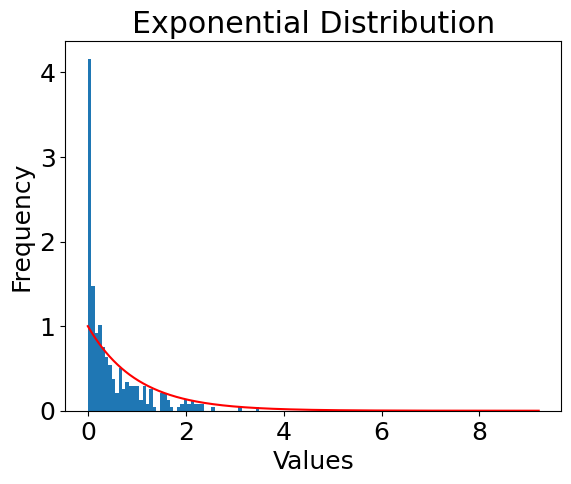

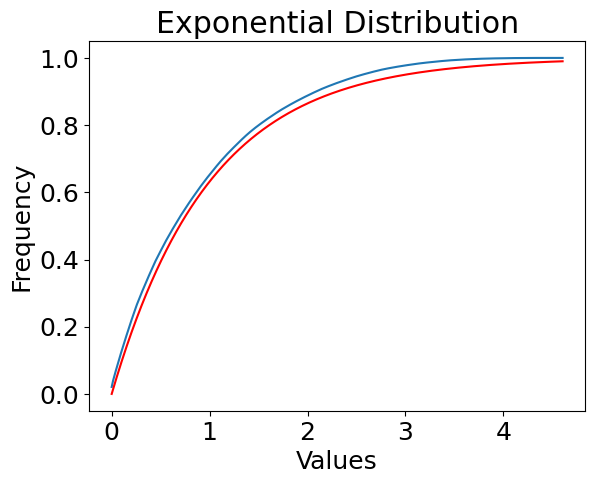

(343,)


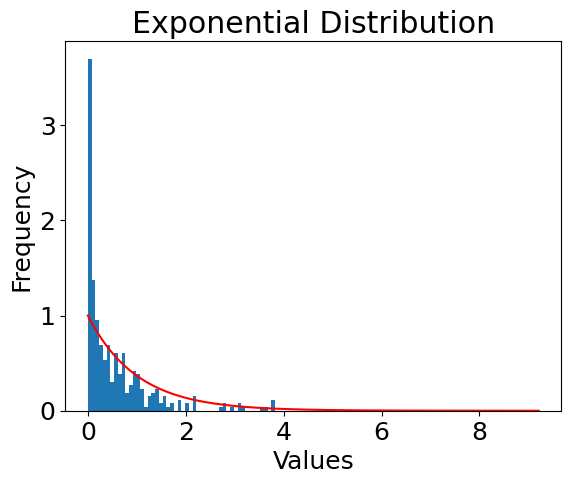

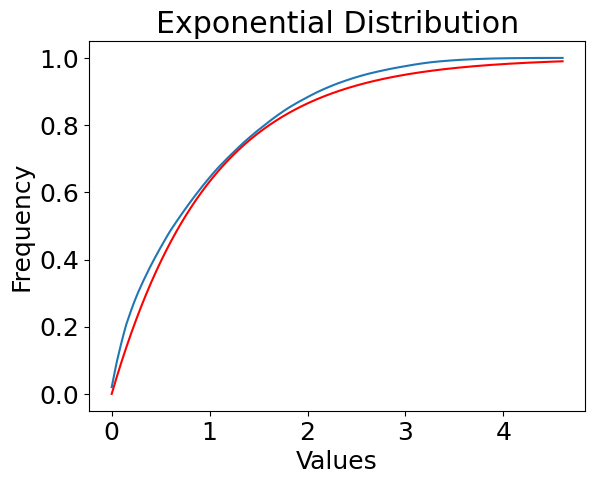

(337,)


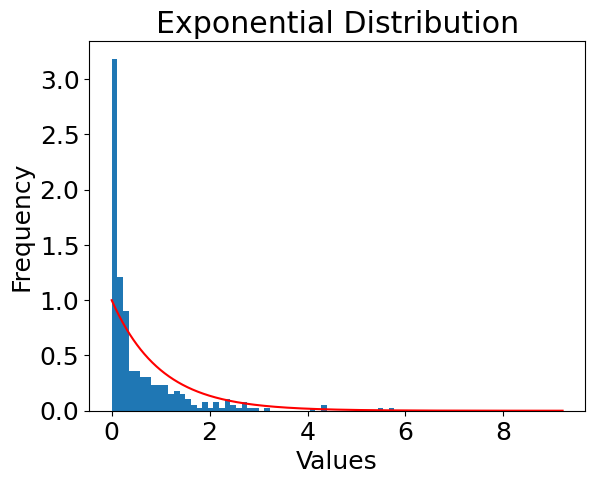

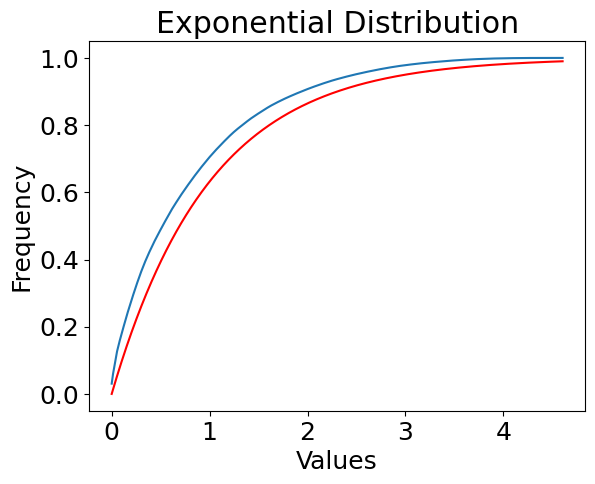

(342,)


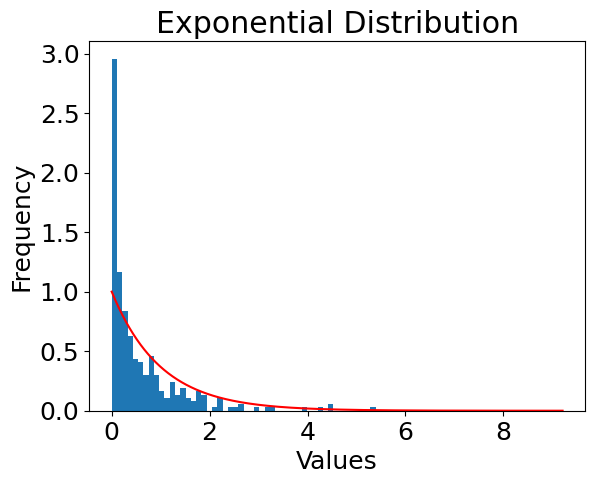

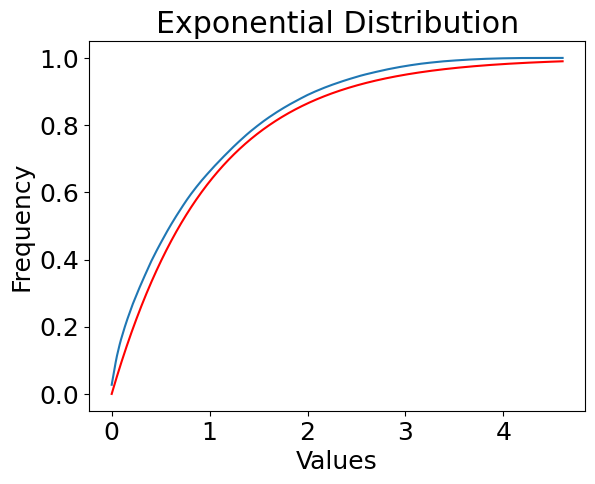

(334,)


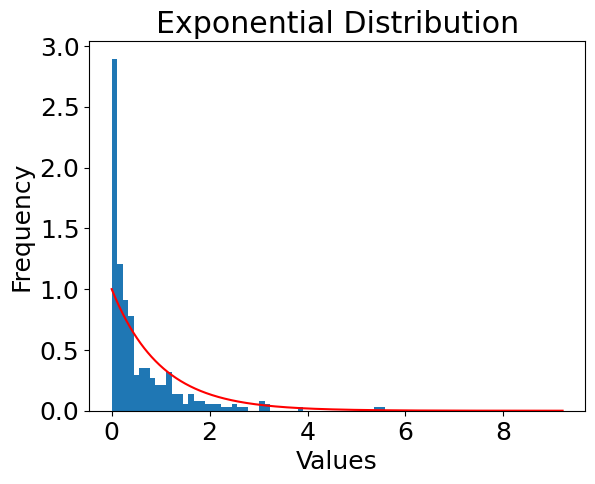

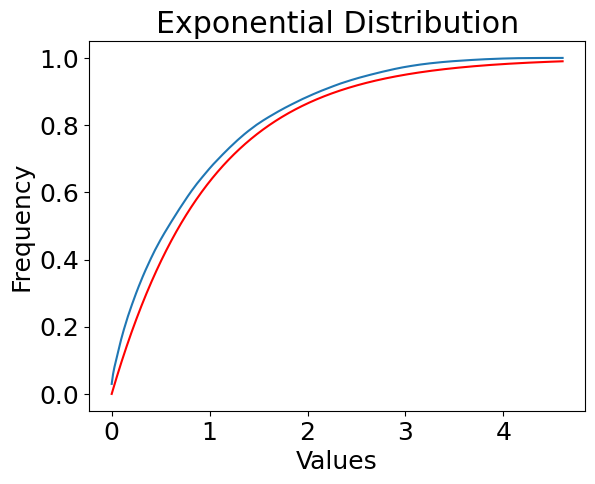

(341,)


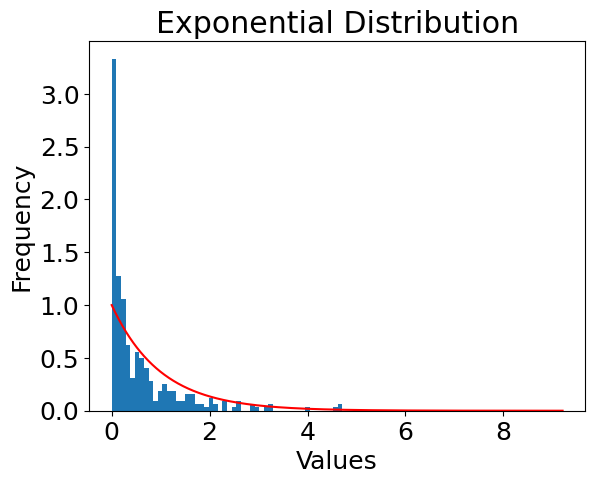

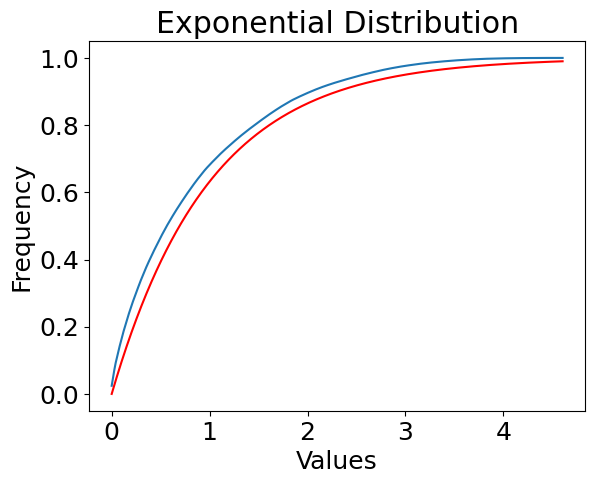

In [119]:
for a in alphas:
  print(np.abs(a[a>0]).shape)
  plot_alphas(np.abs(a[a>0]))

In [120]:
sks = []
kurts = []
p_values = []
ad_statistics = []
rates = []

for a in alphas:
    sk, kurt, p, ad, rate = test(np.abs(a[a>0]))
    sks.append(sk)
    kurts.append(kurt)
    p_values.append(p)
    ad_statistics.append(ad)
    rates.append(rate)

Skewness:  1.7508298845274208
Kurtosis:  3.0713630716193583
Rate:  2.010905625614595
KS test statistic: 0.16911526640868801
KS test p-value: 5.70933885692246e-09
AD test statistic: 32.09272448319837
AD critical values: [0.92  1.076 1.339 1.603 1.954]
AD significance levels: [15.  10.   5.   2.5  1. ]
Skewness:  2.2561578118631695
Kurtosis:  5.894617622021297
Rate:  1.8002940764662267
KS test statistic: 0.16179636076708243
KS test p-value: 2.5929951834060703e-08
AD test statistic: 27.31255159270313
AD critical values: [0.92  1.076 1.339 1.603 1.954]
AD significance levels: [15.  10.   5.   2.5  1. ]
Skewness:  2.818458832389738
Kurtosis:  10.382002245665404
Rate:  1.7851651615660356
KS test statistic: 0.19393321489699855
KS test p-value: 1.4084049080269727e-11
AD test statistic: 38.478597986124896
AD critical values: [0.92  1.076 1.339 1.603 1.954]
AD significance levels: [15.  10.   5.   2.5  1. ]
Skewness:  2.6192768270897053
Kurtosis:  9.064496623305557
Rate:  1.7275642133111813
KS t

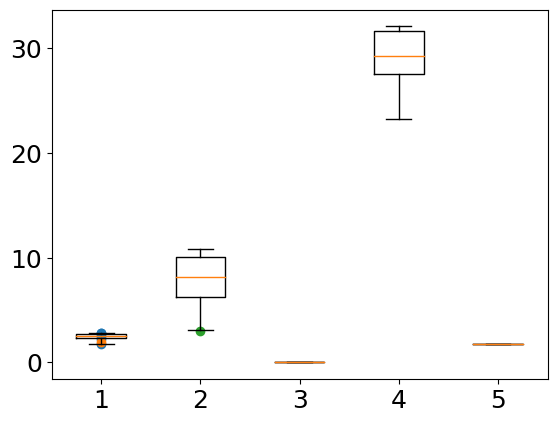

In [121]:
plt.boxplot([sks, kurts, p_values, ad_statistics, rates], showfliers =False);
plt.scatter(x = np.ones_like(sks), y = sks)
plt.scatter(x = [1], y = [2], label = "Exponencial")
plt.scatter(x = [2], y = [3], label = "Laplace")

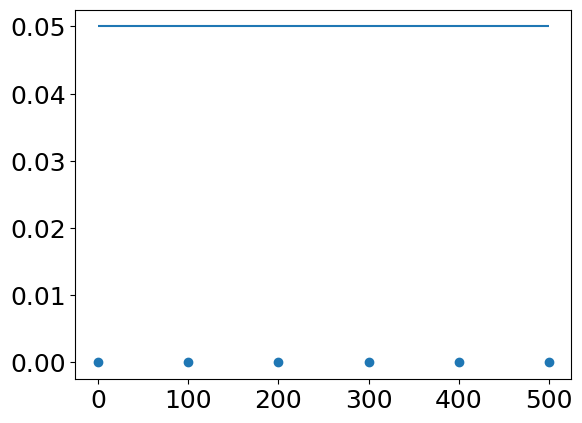

In [122]:
plt.scatter(labels, p_values)
plt.hlines(y = 0.05, xmin = 0, xmax = labels[-1], label = "0.05")

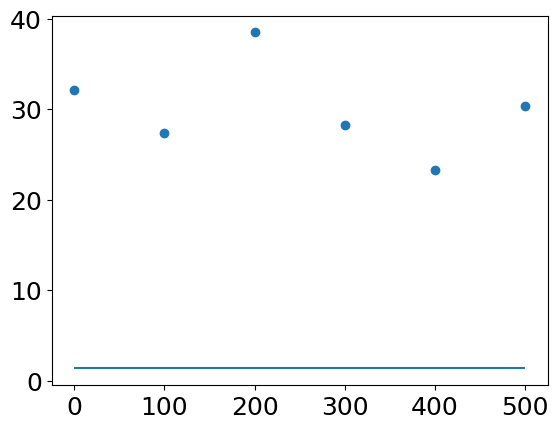

In [123]:
plt.scatter(labels, ad_statistics)
plt.hlines(y = 1.331, xmin = 0, xmax = labels[-1], label = "0.05")